# Kaggle Titanic challenge

## Initial imports

In [2]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
from src import kaggle_api, titanic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [4]:
# Load the train and test data.
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory analysis

What type of columns do we have, and what are their distributions?

In [102]:
print('Numerical columns:')
display(train.describe(include=np.number))
print('Categorical columns:')
display(train.describe(exclude=np.number))
print('Missing values:')
display(pd.concat([
    train_df.iloc[:, 1:].isna().sum().rename('train'),
    test_df.isna().sum().rename('test')
], axis=1))

Numerical columns:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Categorical columns:


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Marvin, Mr. Daniel Warner",male,347082,G6,S
freq,1,577,7,4,644


Missing values:


,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


The data inclues 10 columns of different types and complexity:
- Simple categorical values: `Sex`, `Embarked`, and `Pclass`.
- Discrete values: `SibSp` and `Parch`.
- Continuous values: `Age` (slightly skewed) and `Fare` (highly skewed).
- More complex values: `Ticket`, `Cabin`, and `Name`.

_Note: `Age` and `Cabin` contain many missing values._

### Simple categorical values

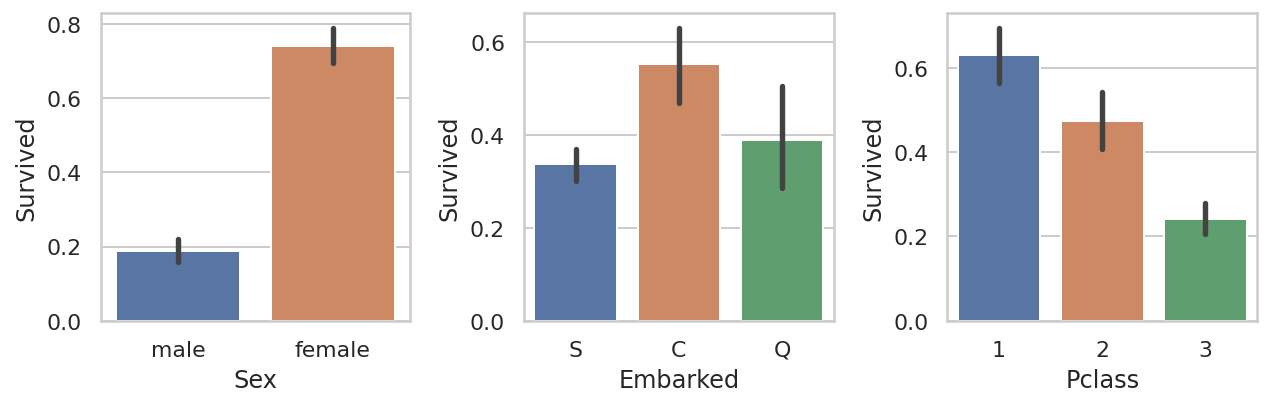

In [116]:
categorical_columns = ['Sex', 'Embarked', 'Pclass']

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, categorical_column in enumerate(categorical_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

### Discrete values

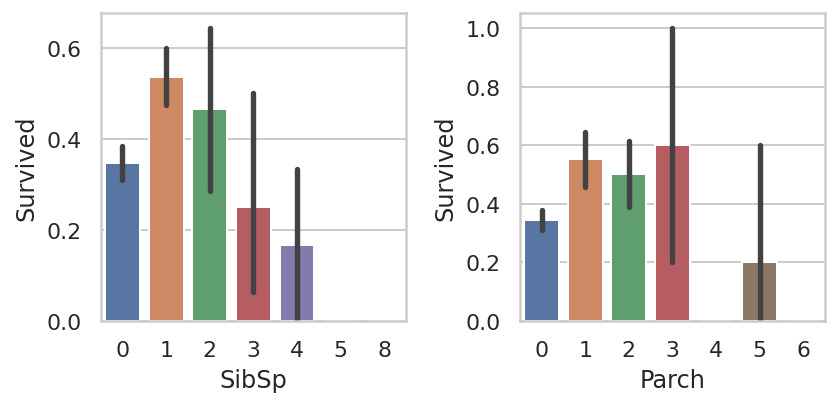

In [117]:
discrete_columns = ['SibSp', 'Parch']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

### Continuous values

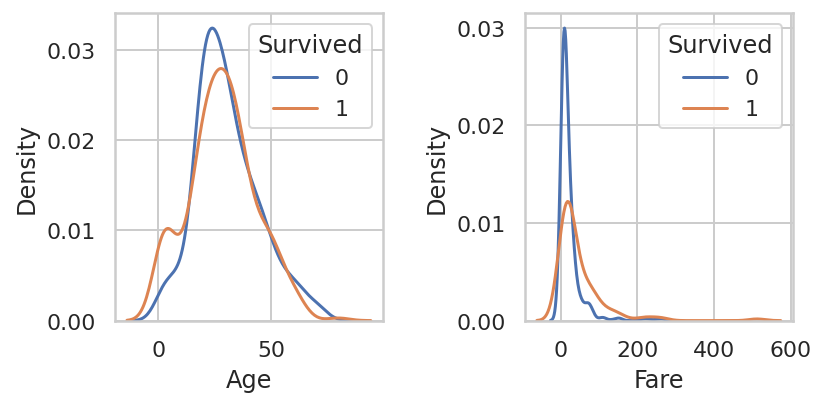

In [181]:
discrete_columns = ['Age', 'Fare']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.kdeplot(data=train[train['Survived'] == 0], x=categorical_column, ax=axes[i], label='0')
    sns.kdeplot(data=train[train['Survived'] == 1], x=categorical_column, ax=axes[i], label='1')
    axes[i].legend(title='Survived')
plt.tight_layout()

### More complex values

#### Name

In [211]:
train['Name'].sort_values().head()

862                      Abbing, Mr. Anthony
390              Abbott, Mr. Rossmore Edward
389         Abbott, Mrs. Stanton (Rosa Hunt)
426                      Abelson, Mr. Samuel
427    Abelson, Mrs. Samuel (Hannah Wizosky)
Name: Name, dtype: object

Two potential new pieces of information can be gained from the name:

- The title (i.e. "importance") of a passenger.
- Which passengers were likely to be part of the same family.

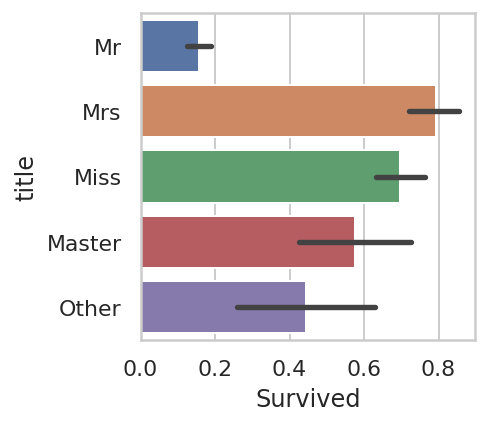

In [11]:
train = train.replace(
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 
    'Dyer-Edwards, Countess. Lucy Noel Martha'
)
for df in (train, test):
    extracted = df['Name'].str.extract(r"^(.+?),\s(\w+)\.([\w\s]+)") \
        .rename({0: 'last_name', 1: 'title', 2: 'first_name'}, axis=1)
    for col in extracted:
        df[col] = extracted[col]
    df.loc[~df['title'].isin(['Mr', 'Mrs', 'Miss', 'Master']), 'title'] = 'Other'
    
sns.barplot(data=train, y='title', x='Survived');

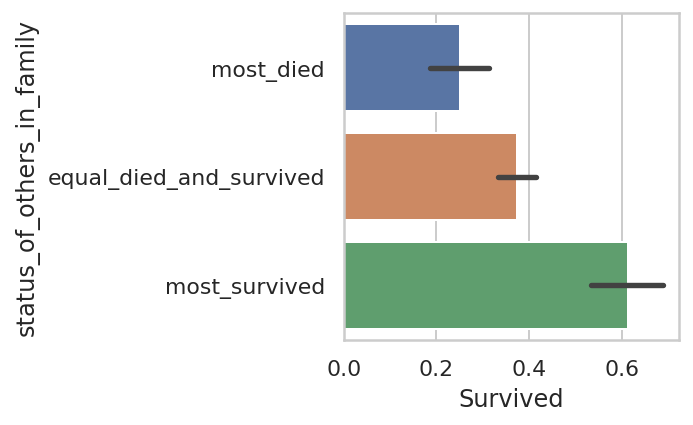

In [12]:
train['status_of_others_in_family'] = titanic.status_of_others_sharing_factor('last_name', train)
sns.barplot(data=train, y='status_of_others_in_family', x='Survived');

#### Cabin number

In [353]:
train.loc[~train['Cabin'].isna(), 'Cabin'].sort_values().to_numpy()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B18', 'B19', 'B20', 'B20', 'B22', 'B22', 'B28', 'B28', 'B3',
       'B30', 'B35', 'B35', 'B37', 'B38', 'B39', 'B4', 'B41', 'B42',
       'B49', 'B49', 'B5', 'B5', 'B50', 'B51 B53 B55', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B57 B59 B63 B66', 'B58 B60', 'B58 B60', 'B69',
       'B71', 'B73', 'B77', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86',
       'B94', 'B96 B98', 'B96 B98', 'B96 B98', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C123', 'C124',
       'C124', 'C125', 'C125', 'C126', 'C126', 'C128', 'C148', 'C2', 'C2',
       'C22 C26', 'C22 C26', 'C22 C26', 'C23 C25 C27', 'C23 C25 C27',
       'C23 C25 C27', 'C23 C25 C27', 'C30', 'C32', 'C45', 'C46', 'C47',
       'C49', 'C50', 'C52', 'C52', 'C54', 'C62 C64', 'C65', 'C65', 'C68',
       'C68', 'C7', 'C70', 'C78', 'C78', 'C82', 'C83', 'C83', 'C85',


Three potential pieces of information can be gained from the cabin number:
- The deck of the cabin (the letter of the cabin).
- Whether the cabin is in the bow or stern of the ship (the number of the cabin).
- Which people were together in the same cabin.

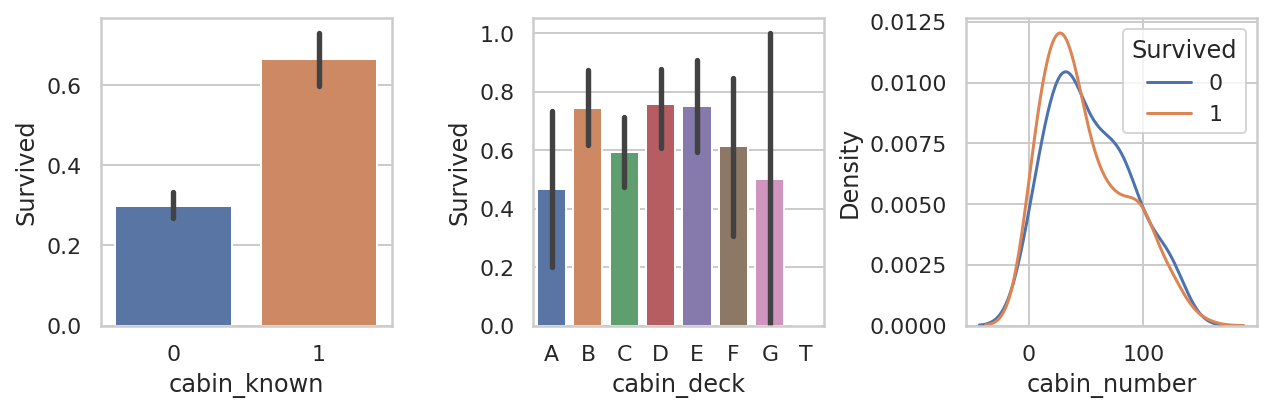

In [374]:
train['cabin_known'] = (~train['Cabin'].isna()).astype(int)
train['cabin_deck'] = train['Cabin'].str.slice(0, 1)
train['cabin_number'] = train['Cabin'].str.extract(r'(\d+)$').astype(float)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=train, x='cabin_known', y='Survived', ax=axes[0])
sns.barplot(data=train, x='cabin_deck', y='Survived', order=sorted(train['cabin_deck'].fillna('A').unique()), ax=axes[1])
sns.kdeplot(data=train[train['Survived'] == 0], x='cabin_number', label='0', ax=axes[2])
sns.kdeplot(data=train[train['Survived'] == 1], x='cabin_number', label='1', ax=axes[2])
axes[2].legend(title='Survived')
plt.tight_layout()

In [7]:
a=titanic.status_of_others_sharing_factor('Cabin', train)
type(a)

pandas.core.series.Series

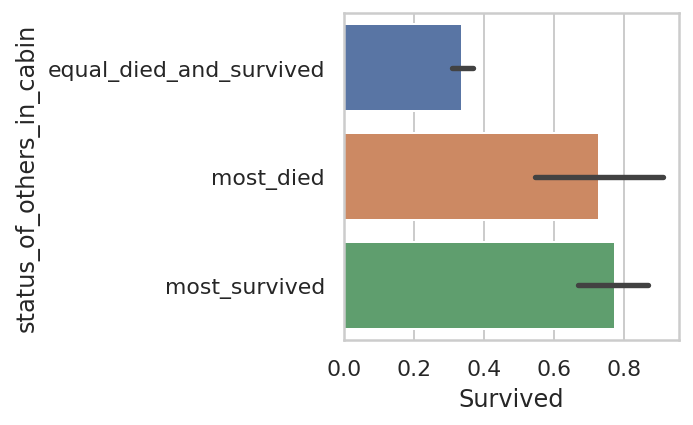

In [10]:
train['status_of_others_in_cabin'] = titanic.status_of_others_sharing_factor('Cabin', train)
sns.barplot(data=train, y='status_of_others_in_cabin', x='Survived');

#### Ticket number

In [166]:
train = train.merge(pd.concat([train, test]).assign(Ticket_count=1).groupby('Ticket')['Ticket_count'].count(), on='Ticket')

<AxesSubplot:xlabel='asdf', ylabel='Count'>

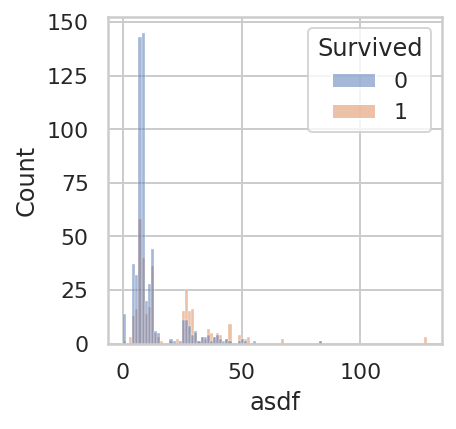

In [167]:
train['asdf'] = train['Fare'] / train['Ticket_count']
sns.histplot(data=train, x='asdf', hue='Survived')

## Clean data

,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


In [6]:
test_submission = (test['Sex'] != 'male').rename('Survived').astype(int)
kaggle_api.submit('titanic', test_submission, 'Test submission from API that should fail')

100%|██████████| 2.77k/2.77k [00:00<00:00, 4.33kB/s]


'0.76555'